In [1]:
import numba as nb
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

from statsforecast.models import ARIMA

import warnings
warnings.filterwarnings("ignore")

/home/krzyszof/Desktop/rotma/.venv/lib/python3.11/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
df = pd.read_csv('/home/krzyszof/Downloads/^SPX (1).csv').set_index('Date')
df.index = pd.DatetimeIndex(df.index)

In [3]:
def metrics(real, predicted, tr_c):

    ret_real = (real[2:]/real[1:-1]) - 1
    ret_predicted = (predicted[2:]/predicted[1:-1]) - 1

    MSE = np.sum((real-predicted)**2)
    MADL = np.sum(-np.sign(ret_real*ret_predicted)*ret_real)

    usd = 1
    ind = 0
    usd_devaluated = np.empty(real.shape[0]-1)

    for t in range(1, real.shape[0]):

        if predicted[t] > real[t-1]*(1+tr_c):
            ind += usd/(real[t-1]*(1+tr_c))
            usd = 0
        elif predicted[t] < real[t-1]/(1+tr_c):
            usd += ind*real[t-1]/(1+tr_c)
            ind = 0

        usd_devaluated[t-1] = usd + ind*real[t-1]/(1+tr_c)
    
    usd += ind*real[-1]/(1+tr_c)
    
    algo_return = (usd_devaluated[1:]/usd_devaluated[:-1])-1
    
    usd += ind*real[-1]/(1+tr_c)
    ind = 0
    if usd-1>0:
        ret_alg1 = ((usd-1)**(252/(real.shape[0]-1))) - 1
    else:
        ret_alg1 = np.nan
    ret_alg2 = np.prod(1+algo_return)**(252/(real.shape[0]-1)) - 1

    ret_std_alg = 252**(1/2) * np.std(algo_return)

    IR = ret_alg2/(ret_std_alg+0.000001)

    usd_devaluated_bh = np.empty(real.shape[0]-1)

    ind = 1/(real[0]*(1+tr_c))
    for t in range(1, real.shape[0]):
        usd_devaluated_bh[t-1] = ind*real[t-1]/(1+tr_c)
    usd = ind*real[-1]/(1+tr_c)

    MD = np.min((usd_devaluated-usd_devaluated_bh)/usd_devaluated)

    return MSE, MADL, ret_alg1, ret_alg2, ret_std_alg, IR, MD, usd_devaluated, usd_devaluated_bh


In [189]:
class ModelARIMA:
    def __init__(self, data, data_val, tr_c):

        self.data = data
        self.data_val = data_val
        self.hiperparams_grid = {'p':[0], 
                                 'd':[1, 2, 3, 4, 5, 6, 7], 
                                 'q':[1, 2, 3, 4, 5, 6, 7]}
    
        self.tr_c = tr_c

    def hiperparam_fit(self, criterion=('MADL', 'min')):

        self.res = {}

        _, values = zip(*self.hiperparams_grid.items())
        perms_params = list(itertools.product(*values))

        full_hist = np.concatenate((self.data, self.data_val))

        for params in tqdm(perms_params):

            ar_ = ARIMA(params)
            ar_.fit(self.data)

            predicted = np.empty(self.data_val.shape)
            for t in range(self.data_val.shape[0]):
                predicted[t] = ar_.forward(full_hist[:self.data.shape[0]+t], 1)['mean'][0]
            
            MSE, MADL, ARC1, ARC2, ASD, IR, MD, EQUITY, EQUITY_ben = metrics(
                self.data_val, predicted, self.tr_c
                )
            
            self.res[params] = {'MSE':MSE, 
                           'MADL':MADL, 
                           'ARC1':ARC1, 
                           'ARC2':ARC2, 
                           'ASD':ASD, 
                           'IR':IR, 
                           'MD':MD, 
                           'EQUITY':EQUITY, 
                           'EQUITY_ben':EQUITY_ben}
            
        best_params = [(k, self.res[k][criterion[0]]) for k in self.res]
        if criterion[1] == 'max':
            ml = -1
        else:
            ml = 1
        best_hiper = sorted(best_params, key=lambda x: ml*x[1])[0][0]
        self.model = ARIMA(best_hiper)
        self.model.fit(full_hist)

In [205]:
class Enviroment:
    def __init__(self, data, tr_c):

        self.tr_c = tr_c

        self.data = data
        
    def split_data(self, initial_train_end, window_months):

        intervals = pd.date_range(pd.to_datetime(initial_train_end), 
                                  self.data.index.max(), freq='%sm' % window_months)

        self.data_feed = []
        for train_stop, val_stop, test_stop in zip(intervals, intervals[1:], intervals[2:]):
            self.data_feed.append((self.data[:train_stop], 
                              self.data[train_stop:val_stop], 
                              self.data[val_stop:test_stop]))
        
    def train_test_model_step(self):

        self.res = []
        self.models = []

        for train, val, test in self.data_feed:

            full_hist = np.concatenate((train, val, test))
            
            self.model = ModelARIMA(train.values, val.values, self.tr_c)

            self.model.hiperparam_fit()

            predicted = pd.Series(test.shape[0], index=test.index)
            for t in range(test.shape[0]):
                predicted[t] = self.model.model.forward(full_hist[:train.shape[0]+val.shape[0]+t], 1)['mean'][0]
            
            MSE, MADL, ARC1, ARC2, ASD, IR, MD, EQUITY, EQUITY_ben = metrics(
                test.values, predicted.values, self.tr_c
                )
            
            self.res.append({'MSE':MSE, 
                           'MADL':MADL, 
                           'ARC1':ARC1, 
                           'ARC2':ARC2, 
                           'ASD':ASD, 
                           'IR':IR, 
                           'MD':MD, 
                           'EQUITY':EQUITY, 
                           'EQUITY_ben':EQUITY_ben,
                           'predicted':predicted,
                           'real':test})
            
            self.models.append(self.model)

        self.out_of_sample_predict = pd.concat([k['predicted'] for k in self.res])
        self.out_of_sample_realized = pd.concat([k['real'] for k in self.res])

        self.total_metrics = metrics(self.out_of_sample_realized, self.out_of_sample_predict, self.tr_c)

In [206]:
env = Enviroment(df['Close'], 0.0005)

In [207]:
env.split_data('1988-12-30', 6)

In [208]:
env.train_test_model_step()

100%|██████████| 49/49 [00:15<00:00,  3.17it/s]


In [210]:
MSE, MADL, ARC1, ARC2, ASD, IR, MD, EQUITY, EQUITY_ben = env.total_metrics

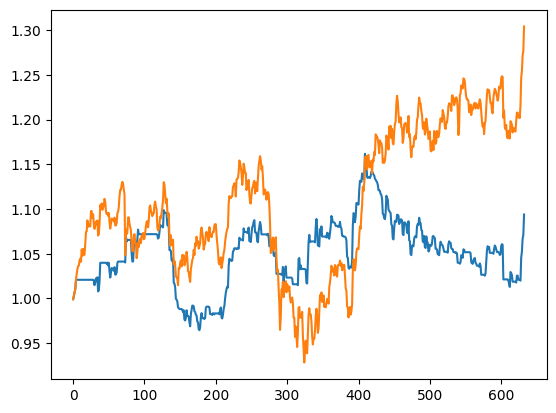

In [221]:
plt.plot(EQUITY)
plt.plot(EQUITY_ben)

In [224]:
pd.Series(data=[MSE, MADL, ARC1, ASD, IR, MD], index=['MSE', 'MADL', 'ARC', 'ASD', 'IR', 'MD'])

MSE     116967.065262
MADL         0.000000
ARC          0.074550
ASD          0.101840
IR           0.360996
MD          -0.192362
dtype: float64